# RNA Velocity

As a powerful assessment of cell status, RNA velocity analyses expression dynamics based on scRNA-seq data, which generates the spliced and unspliced matrices in loom file, also called RNA abundance.


For example, we use exon information of GEM/GEF file to generate the spliced and unspliced matrices in the loom file. Therefore, it is necessary to ensure that GEM/GEF file is obtained from `spatial_RNA_visualization_v5` in SAP or SAW (version >= 5.1.3). 

The annotation logic in SAW is calculating overlap area with exon. If the overlap area with exon information is greater than 50%, it is considered that the transcript belongs to exon.

## Loom file

Import the module to generate loom file, please download our [example data](http://116.6.21.110:8090/share/dd965cba-7c1f-40b2-a275-0150890e005f) previously.

In [5]:
from stereo.tools import generate_loom

bgef_file = './SS200000135TL_D1.tissue.gef'
gtf_file = './genes.gtf'
out_dir = './SS200000135TL_D1_bgef'

# generate loom file
loom_data = generate_loom(
                gef_path=bgef_file, 
                gtf_path=gtf_file, 
                bin_type='bins', 
                bin_size=100, 
                out_dir=out_dir
                )

[2023-04-03 10:56:33][Stereo][20511][MainThread][139671934703424][rna_velocity][66][INFO]: Getting layers
[2023-04-03 10:58:22][Stereo][20511][MainThread][139671934703424][rna_velocity][77][INFO]: Getting row attrs from gtf
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'tag', 'ccds_id', 'protein_id', 'protein_version']
[2023-04-03 11:09:37][Stereo][20511][MainThread][139671934703424][rna_velocity][80][INFO]: Generating loom


<div class="alert alert-info">

**Note**

If you want to generate loom file through GEM file, use the parameter `gem_path`. Pay attention to the parameter `bin_type` which must be set to `'cell_bins'` when use files of `.cellbin.gef` or `.cellbin.gem`.

</div>

## Analysis on Dynamo

We recommend Dynamo to subsequent analysis of RNA velocity. Now that Dynamo has been released to PyPI, learn about the usage on its [document](https://dynamo-release.readthedocs.io/en/latest/ten_minutes_to_dynamo.html). Dynamo now has been released to PyPI, you can install the PyPI version via: `pip install dynamo-release` and `pip install cdlib`.

In [ ]:
#pip install dynamo-release
#pip install cdlib
import dynamo as dyn

# set visualization mode
dyn.configuration.set_figure_params('dynamo', background='white')

# read data
adata = dyn.read_loom(loom_data)
dyn.pp.recipe_monocle(
            adata,
            num_dim=30,
            keep_filtered_genes = True
            )

dyn.tl.dynamics(adata, model='stochastic', cores=60)
dyn.tl.moments(adata)
dyn.tl.reduceDimension(adata)

The spatial coordinates of each cell are stored in the index of `adata.obs.index` which consists of coordinate x and coordiante y.

In [15]:
adata.obs['x'] = list(map(lambda x: float(x.split("_")[0]) ,list(adata.obs.index)))
adata.obs['y'] = list(map(lambda x: float(x.split("_")[1]) ,list(adata.obs.index)))

adata.obsm['spatial'] = adata.obs[['x', 'y']].values.astype(float)
adata.obsm['X_spatial'] = adata.obs[['x', 'y']].values.astype(float)

Leiden clustering after RNA velovity.

In [ ]:
dyn.tl.cell_velocities(
            adata, 
            method='fp', 
            basis='X_spatial', 
            enforce=True,  
            transition_genes = list(adata.var_names[adata.var.use_for_pca])
            )

dyn.tl.cell_wise_confidence(adata)
dyn.tl.leiden(adata, result_key='spatial_leiden_res')

Display the streamline plot of RNA velocity.

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis spatial. dimension reduction spatial will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [28.5842s]
|-----? Some row sums(out degree) in adata's neighbor graph are zero.
|-----> Neighbor graph is broken, recomputing....
|-----> Start 

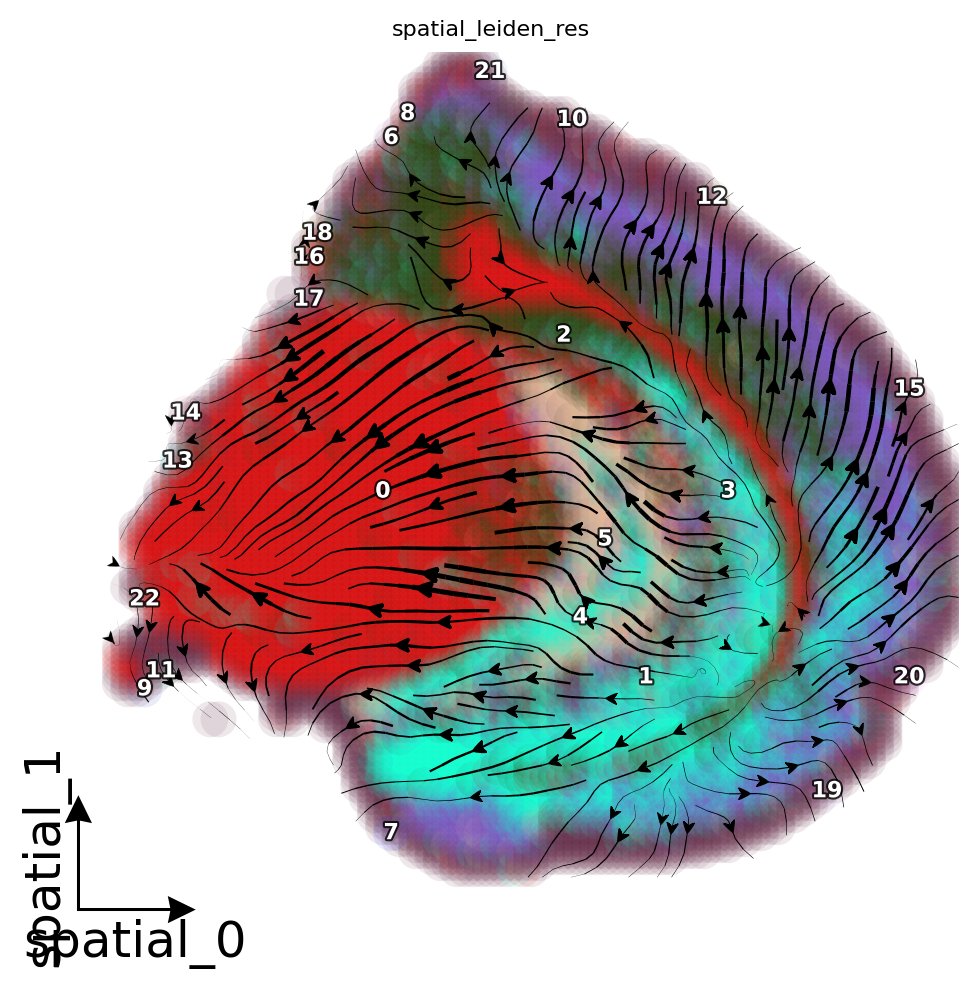

In [19]:
dyn.pl.streamline_plot(
            adata, 
            color = 'spatial_leiden_res', 
            basis='X_spatial',
            quiver_length=6, 
            quiver_size=6,  
            show_arrowed_spines=True,
            figsize=(6, 6)
            )